In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from lib.cross_validation import (
    StratifiedGroupKFoldSplit,
    get_cross_validation_metrics,
    perform_cross_validation,
)
from lib import full_flow_dataloader
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from lib.reproduction import major_oxides
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor

In [18]:
train_full, test_full = full_flow_dataloader.load_full_flow_data(
    load_cache_if_exits=True, average_shots=True
)

In [19]:
full_data = pd.concat([train_full, test_full], axis=0)

In [20]:
target = "MgO"

kf = StratifiedGroupKFoldSplit(n_splits=5, group_by="Sample Name", random_state=42, target=target)
train, test = kf.split(full_data)[0]

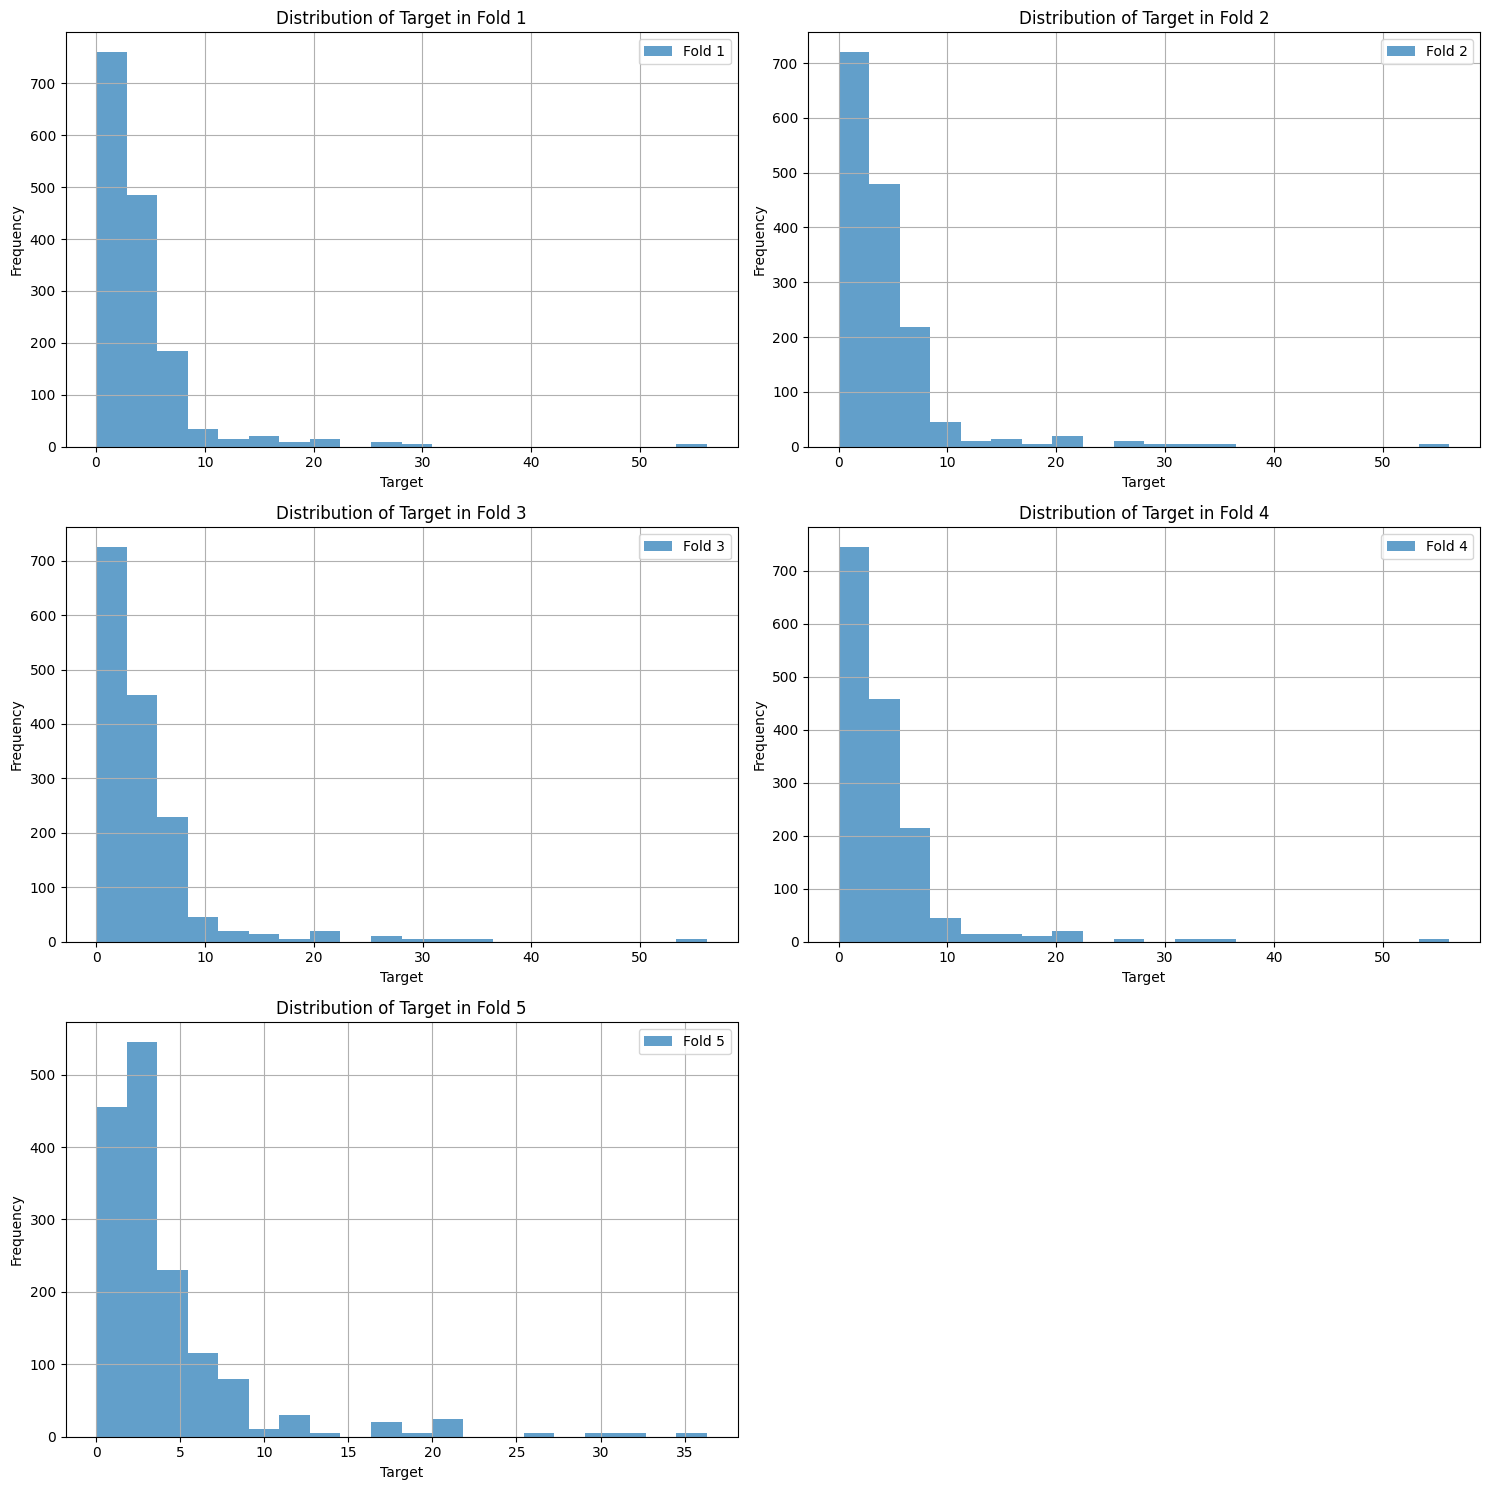

In [21]:
plot_kf = GroupKFold(n_splits=5)

splits = list(plot_kf.split(full_data, groups=full_data["Sample Name"]))

# Make plotting code a function
def plot_target_distribution(data, target, group_by, kf, n_cols=2):
    splits = list(kf.split(data, groups=data[group_by]))
    n_splits = len(splits)
    n_rows = (n_splits + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for fold, (train_idx, _) in enumerate(splits):
        train_fold = data.iloc[train_idx]
        
        # Plot the distribution of the target variable in the training set
        ax = axes[fold]
        ax.hist(train_fold[target], bins=20, alpha=0.7, label=f'Fold {fold + 1}')
        ax.set_title(f'Distribution of Target in Fold {fold + 1}')
        ax.set_xlabel('Target')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True)
    
    # Hide any unused subplots
    for i in range(fold + 1, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
plot_target_distribution(full_data, target, "Sample Name", plot_kf)

In [22]:
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (1539, 6154)
test shape: (389, 6154)


In [23]:
# number of groups in train
print(len(train["Sample Name"].unique()))

# number of groups in test
print(len(test["Sample Name"].unique()))

308
78


In [24]:

drop_cols = ["ID", "Sample Name"] + major_oxides
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(train.drop(drop_cols, axis=1))

# print number of outliers
print(np.sum(outliers == -1))

154


In [25]:
# print number of outliers
print(np.sum(outliers == -1))

154


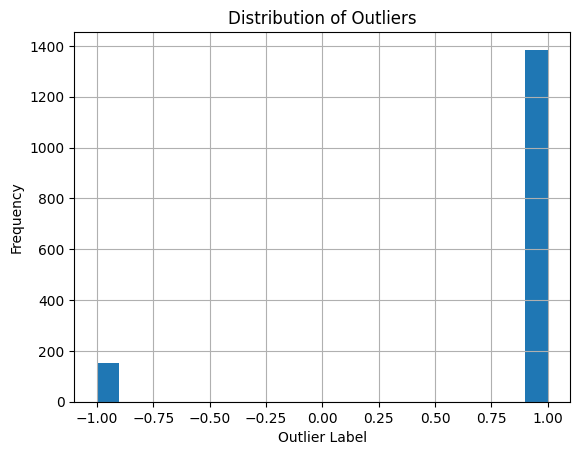

In [26]:
# Plot distribution of outliers
# -1 means outlier, 1 means inlier
plt.hist(outliers, bins=20)
plt.title("Distribution of Outliers")
plt.xlabel("Outlier Label")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

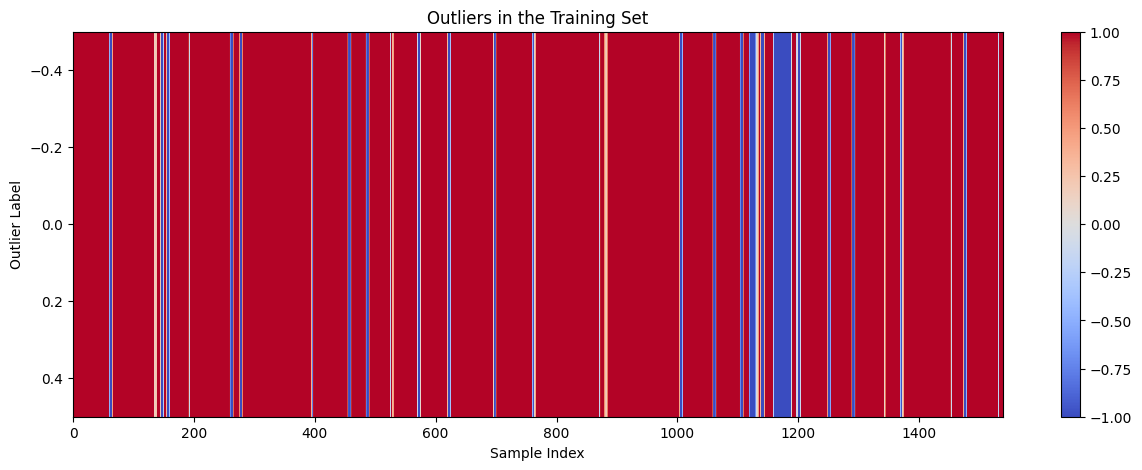

In [27]:
# plot a heatmap of the outliers
plt.figure(figsize=(15, 5))
plt.imshow([outliers], aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Outliers in the Training Set")
plt.xlabel("Sample Index")
plt.ylabel("Outlier Label")
plt.show()


41


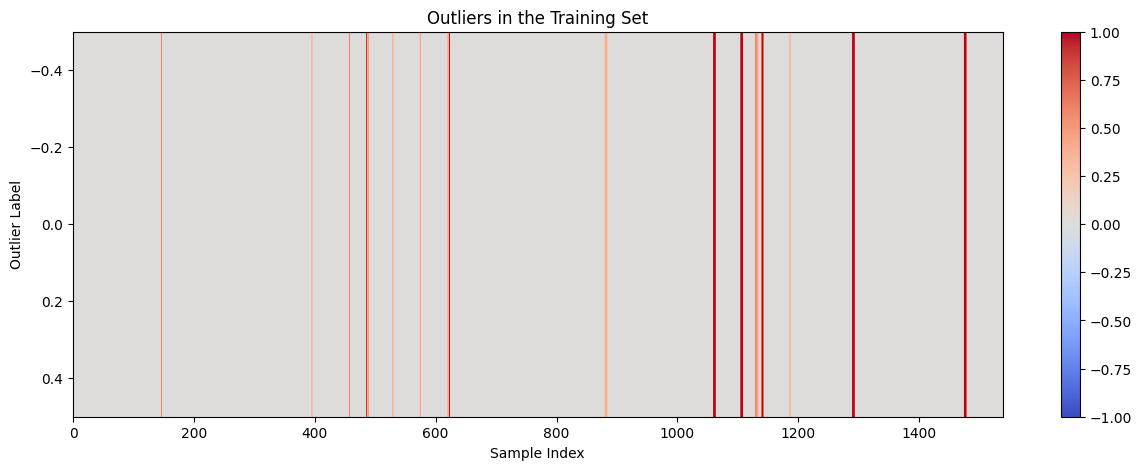

In [28]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest_labels = iso_forest.fit_predict(train.drop(drop_cols, axis=1))

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_labels = lof.fit_predict(train.drop(drop_cols, axis=1))

outlier_labels = {
    'iso_forest_labels': iso_forest_labels,
    'lof_labels': lof_labels
}

combined_outlier_label = (outlier_labels['iso_forest_labels'] == -1) & (outlier_labels['lof_labels'] == -1)

# print removed outliers
print(np.sum(combined_outlier_label))

# plot a heatmap of the outliers
plt.figure(figsize=(15, 5))
plt.imshow([combined_outlier_label], aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Outliers in the Training Set")
plt.xlabel("Sample Index")
plt.ylabel("Outlier Label")
plt.show()


In [29]:
# print samples that are outliers and only the sample column
train[combined_outlier_label]["Sample Name"]

161        jsc1439
490        jsc1409
572          mix6d
605      oreas170a
606      oreas170a
608      oreas170a
664        jsc1452
738        mhc3828
804          mix5d
806          mix5d
807          mix5d
1144         mix5b
1147         mix5b
1353    ncsdc47009
1354    ncsdc47009
1355    ncsdc47009
1356    ncsdc47009
1357    ncsdc47009
1403    ncsdc28041
1404    ncsdc28041
1405    ncsdc28041
1406    ncsdc28041
1407    ncsdc28041
1428            wm
1430            wm
1432            wm
1438        dh4909
1439        dh4909
1440        dh4909
1441        dh4909
1485       mhc2319
85         jsc1425
86         jsc1425
87         jsc1425
88         jsc1425
89         jsc1425
310        jsc1451
311        jsc1451
312        jsc1451
313        jsc1451
314        jsc1451
Name: Sample Name, dtype: object